In [1]:
import numpy as np
import pandas as pd
from multihist import Hist1d, Histdd
import matplotlib.pyplot as plt
import uproot as ur
import awkward as ak
import os

In [2]:
def GetTemplate(f_name, b_name, h_name):
    
    if b_name == 'Accidentals':
        h_template = ur.open(f_name + ':' + h_name)
        np_template = h_template.to_numpy()

        bin_values = np_template[0]
        s1_edges = np_template[1][:]
        s2_edges = np_template[2][:]

        # We want the same dimensions as the other templates, so insert rows of empty bins at cS1 = 0.5, 1.5, 2.5
        s1_edges = np.insert(s1_edges, 0, [0, 1, 2])
        bin_values = np.insert(bin_values, 0, [[0], [0], [0]], axis=0)
    else:
        h_template = ur.open(f_name + ':' + b_name + '/' + h_name)
        np_template = h_template.to_numpy()
            
        bin_values = np_template[0]
        s1_edges = np_template[1][:]
        s2_edges = np_template[2][:]
    
    s1_centers = (s1_edges[1:] + s1_edges[:-1]) / 2.
    s2_centers = (s2_edges[1:] + s2_edges[:-1]) / 2.

    weights = []
    s1_centers_full = []
    s2_centers_full = []

    for i, s1 in enumerate(s1_centers):
        s1_centers_full.extend(np.ones_like(s1_centers) * s1)
        s2_centers_full.extend(s2_centers)
        weights.extend(bin_values[i, :])
            
    np_weights = np.asarray(weights)
    np_s1_centers = np.asarray(s1_centers_full)
    np_s2_centers = np.asarray(s2_centers_full)
    return np_weights, np_s1_centers, np_s2_centers

In [3]:
def GetTimeTemplate(f_name, h_name, bin_width):
    h_time = ur.open(f_name + ':' + h_name)
    divider = 86400 # second to day converter
    time_edges = h_time.axis("x").edges()/divider 
    centers_days = 0.5 * (time_edges[1:] + time_edges[:-1])
    hist_value = h_time.values()/1./divider/(centers_days[1]-centers_days[0])
    bin_size = round(5.0/(centers_days[1]-centers_days[0]))
    start = 0.0
    end =  centers_days[len(centers_days)-1]
    x_centers = np.linspace(start, end, int(end/bin_width), endpoint = False)
    bin= 1
    sum_value = 0.0
    y_values = []
    for count, value in enumerate(hist_value):
        sum_value += value
        if(count == bin*bin_size): 
            #print(bin, count, sum_value/bin_size)
            y_values.append(sum_value/bin_size)
            sum_value = 0.0
            bin += 1
        #elif(count == len(self.hist_value) -1):
        #    y_values.append(sum_value/bin_size)
    return x_centers, y_values
    

In [4]:
def ScaleTemplate(name, scale, weights, time_fraction, t_centers):
    scaled_weight = []

    exp_list = ['Xe127', 'Ar37']
    fiducial_volume = 5521
    bin_width = t_centers[1] - t_centers[0]

    if name == 'Accidentals':
        scale = (1/1000./365.)*fiducial_volume
        
    if name == 'Flat_ER':
        print('Flat_ER', np.sum(weights))
        correction_factor = 3.30 #this is added to correct expected event (cheating!)
        scale = scale*correction_factor
            
    if name in exp_list:
        if name == 'Ar37':
            tau_ar37 = 50.55
            for weight in weights:
                for count, time in enumerate(time_fraction):
                    scaled_weight.append(weight * scale * time * np.exp(-1/tau_ar37 * t_centers[count]) * bin_width)   
        if name == 'Xe127':
            tau_xe127 = 52.44
            scale = scale * (0.00006256) # comes from some corrections
            for weight in weights:
                for count, time in enumerate(time_fraction):
                    scaled_weight.append(weight * scale * time * np.exp(-1/tau_xe127 * t_centers[count]) * bin_width)          
    else:
        for weight in weights:
            for time in time_fraction:
                scaled_weight.append(weight * scale * time * bin_width)    

    scaled_weight = np.asarray(scaled_weight)            
    return scaled_weight 


In [5]:
def GetMultiHist(x_centers, y_centers, weights):
    x_data = []
    y_data = []
    for y in y_centers:
        for x in x_centers:
            x_data.append(x)
            y_data.append(y)
    np_x_data = np.asarray(x_data)      
    np_y_data = np.asarray(y_data)     
    np_hist, np_x_edges, np_y_edges =  np.histogram2d(np_x_data , np_y_data, bins=[23, 80], weights=weights)
    mh = Histdd(bins=[23, 80]).from_histogram(np_hist, bin_edges=[np_x_edges, np_y_edges])
    return mh

In [6]:
def GetTimeMultiHist(t_centers, s1_centers, s2_centers, weights):
    data = np.empty((0,3), float)
    for t in t_centers:
        for s1 in range(0, 80):
            for s2 in range(0, 80):
                new_element =  np.array([[t, s1_centers[s1], s2_centers[s2]]])
                data = np.append(data, new_element, axis=0)

    np_hist, np_edges = np.histogramdd(data, bins = (23, 80, 80), weights = weights)
    mh = Histdd(bins=[80, 80, 23]).from_histogram(np_hist, bin_edges=np_edges)
    return mh, np_hist, np_edges

In [7]:
acc_bkg_file = '/global/cfs/cdirs/lz/data/LZStats_data/LowE_NR_group/input/SR1/sr1_final_inputs/accidentals_pdf_chopstitch_outerproduct_S1S2_low_S1c_thres.root'
data_file = '/global/cfs/cdirs/lz/data/LZStats_data/LowE_ER_group/SR1/BGAssembler_output/Final/BGAssembler_SR1_LowE-ER_Signals_Backgrounds_LZLAMA-3.3.4_NEST_default_AllSR1WSCuts_AllSR1WSaccept_v2.root'
livetime_file = '/global/cfs/cdirs/lz/physics/WS/SR1/v37-20220612/SR1WSAnalysis_SR1-WSv5_LZAP-5.4.6_v37.root'

backgrounds = ["B8", "Solar_ER", "Xe136", "Flat_NR" , "Ar37", "Xe124", "Xe127", "Accidentals", "Kr85", "Pb214", "Pb212", "Flat_ER"]
background_rate_scale = [1, 1, 1, 1, 0.011*(52.5/97.953), 1, 92.9*(9.19225/8.557), 1, 0.144/0.3, 3.26, 0.137, 1]

bg_dir = 'Backgrounds'
sg_dir = 'Signals'

sys_uncerts = [0.06, 0.06, 0.16, 0.10, 0.50, 0.28, 0.09, 0.21, 0.16, 0.21, 0.27, 0.27]

signals = ["SolarNuMM"]

bin_width = 5.0 # days
time_centers, live_fraction = GetTimeTemplate(livetime_file, 'h_physicsLT_ODV_time', bin_width) 


bg_dir_check = os.path.exists(os.getcwd() + '/' + bg_dir)
sg_dir_check = os.path.exists(os.getcwd() + '/' + sg_dir)
if bg_dir_check == False:
    os.makedirs(bg_dir)
if sg_dir_check == False:
    os.makedirs(sg_dir)

bkg_dict = dict()
bkg_s1_time_dict = dict()
bkg_s2_time_dict = dict() 
sig_dict = dict()
sig_s1_time_dict = dict()
sig_s2_time_dict = dict()

summed_background_count = 0.0
summed_background_sys = 0.0

for count, background in enumerate(backgrounds):
    if background == 'Accidentals':
        weights, s1_centers, s2_centers = GetTemplate(acc_bkg_file, background, 'h_S1logS2')
    else:    
        weights, s1_centers, s2_centers = GetTemplate(data_file, background, 'logS2vS1')
    
    scaled_weight = ScaleTemplate(background, background_rate_scale[count], weights, live_fraction, time_centers)
    print(background, np.sum(scaled_weight), '+/-' , sys_uncerts[count] * np.sum(scaled_weight))

    bkg_s1_time_dict[background] = GetMultiHist(time_centers, s1_centers, scaled_weight)
    bkg_s2_time_dict[background] = GetMultiHist(time_centers, s2_centers, scaled_weight)

    bkg_dict[background], hist_values, edges = GetTimeMultiHist(time_centers, s1_centers, s2_centers, scaled_weight)
    np.savez(f'{bg_dir}/{background}', hist_values=hist_values, time_edges=edges[0], s1_edges=edges[1], s2_edges=edges[2])

    if(background == "Kr85" or background == "Pb214" or background == "Pb212" or background == "Flat_ER"):
        summed_background_count += np.sum(hist_values)
        summed_background_sys += sys_uncerts[count] * np.sum(scaled_weight) * sys_uncerts[count] * np.sum(scaled_weight)
        #print(summed_background_count, np.sqrt(summed_background_sys))

for count, signal in enumerate(signals):
    weights, s1_centers, s2_centers = GetTemplate(data_file, signal, 'logS2vS1')
    scaled_weight = ScaleTemplate(signal, 1.0, weights, live_fraction, time_centers)
    print(signal, np.sum(scaled_weight))

    sig_s1_time_dict[signal] = GetMultiHist(time_centers, s1_centers, scaled_weight)
    sig_s2_time_dict[signal] = GetMultiHist(time_centers, s2_centers, scaled_weight)    
    
    sig_dict[signal], hist_values, edges = GetTimeMultiHist(time_centers, s1_centers, s2_centers, scaled_weight)   
    np.savez(f'{sg_dir}/{signal}', hist_values=hist_values, time_edges=edges[0], s1_edges=edges[1], s2_edges=edges[2])

B8 0.14103861060359713 +/- 0.008462316636215828
Solar_ER 27.165270609693824 +/- 1.6299162365816293
Xe136 15.104465621401191 +/- 2.4167144994241907
Flat_NR 0.3290351506375046 +/- 0.032903515063750464
Ar37 54.153334739365256 +/- 27.076667369682628
Xe124 5.007883677139958 +/- 1.4022074295991884
Xe127 9.213306757285483 +/- 0.8291976081556934
Accidentals 1.2198842074144278 +/- 0.25617568355702985
Kr85 32.38856860313688 +/- 5.182170976501901
32.38856860313688 5.182170976501901
Pb214 164.69642794274833 +/- 34.586249867977145
197.0849965458852 34.97232585859636
Pb212 17.625703156887507 +/- 4.758939852359627
214.7106997027727 35.29463251654881
Flat_ER 0.006021323
Flat_ER 1.1964551373303716 +/- 0.32304288707920037
215.90715484010306 35.296110850703045
SolarNuMM 163.51345651467565


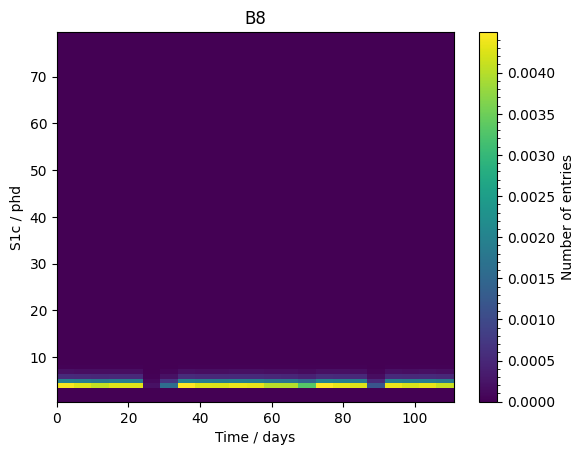

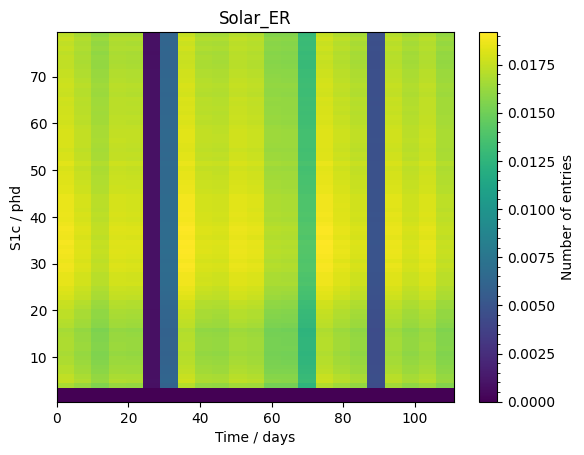

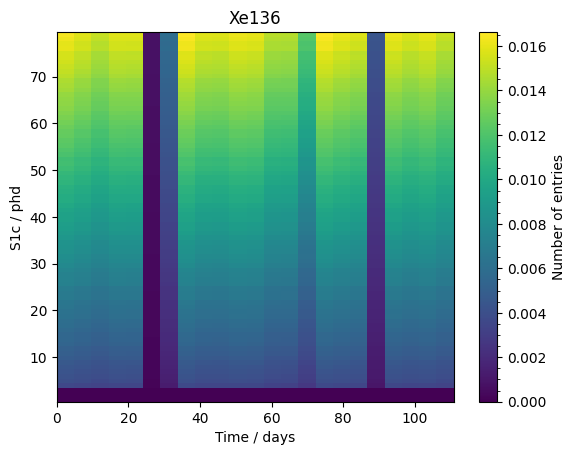

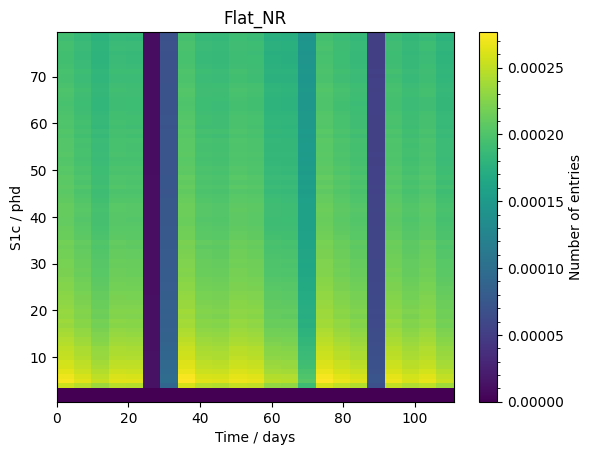

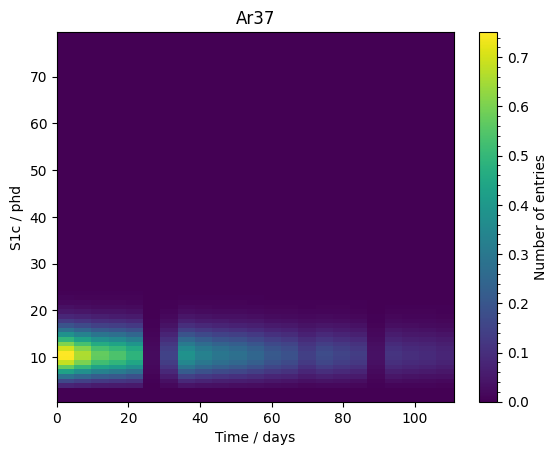

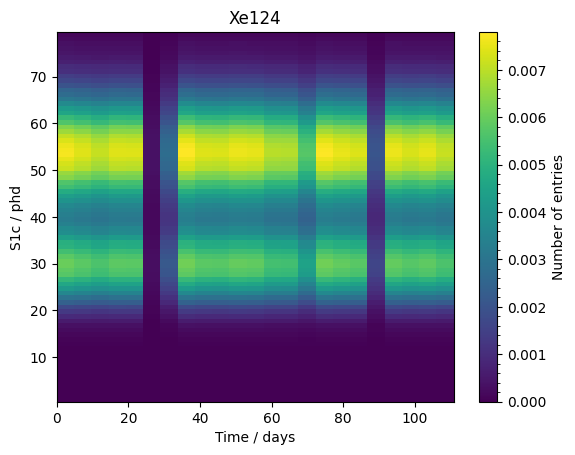

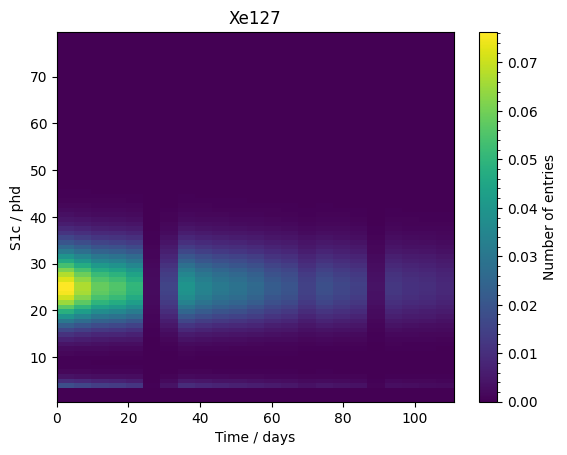

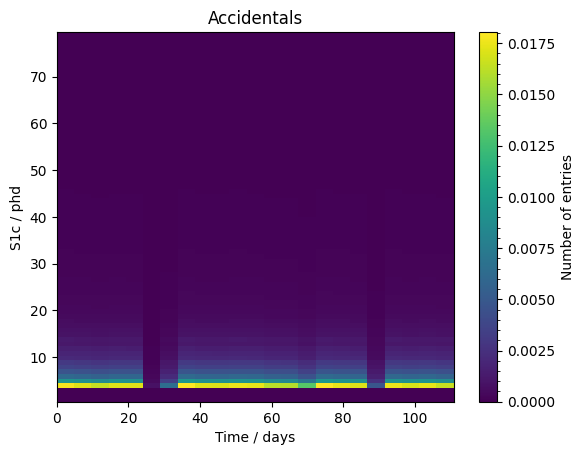

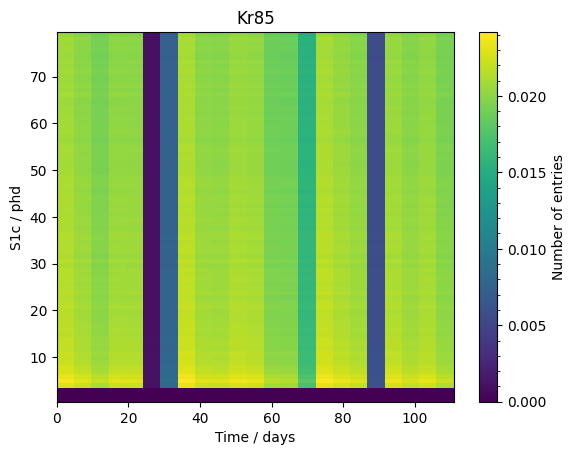

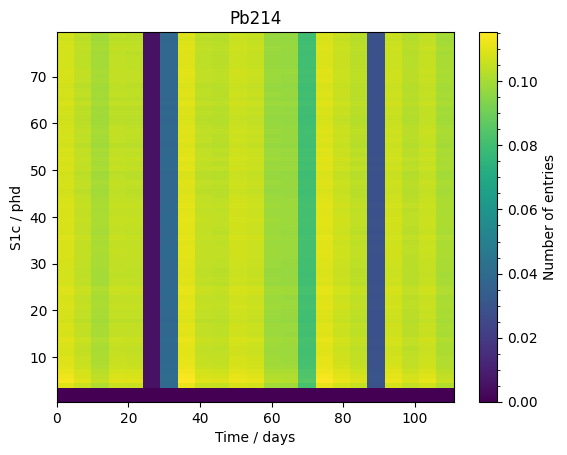

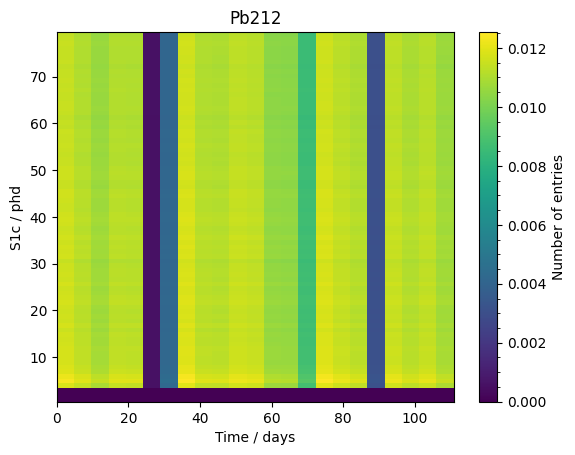

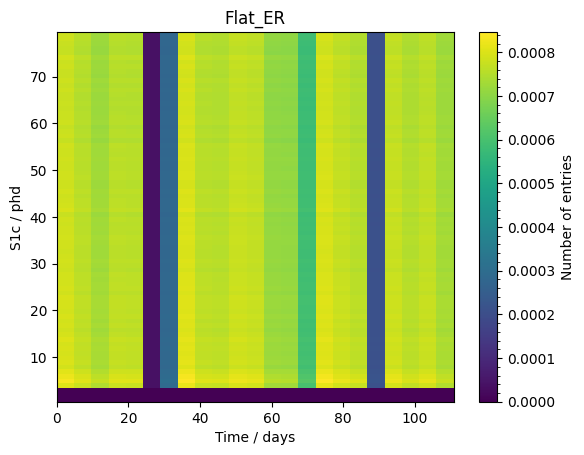

In [8]:
for background in backgrounds:
    plt.title(background)
    plt.xlabel('Time / days')
    plt.ylabel('S1c / phd')
    bkg_s1_time_dict[background].plot()
    plt.show()

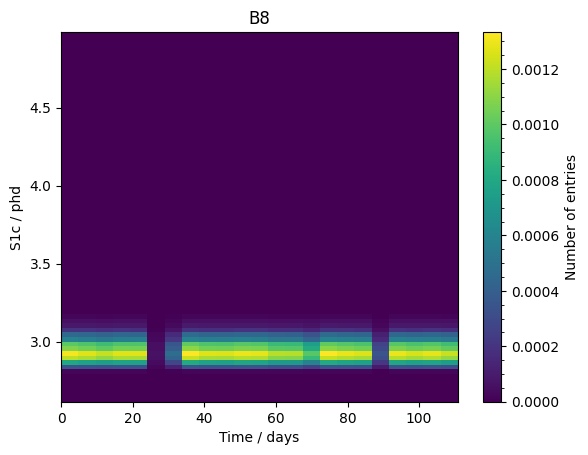

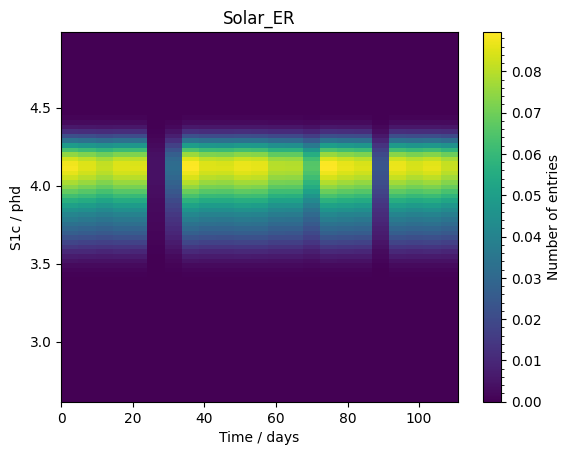

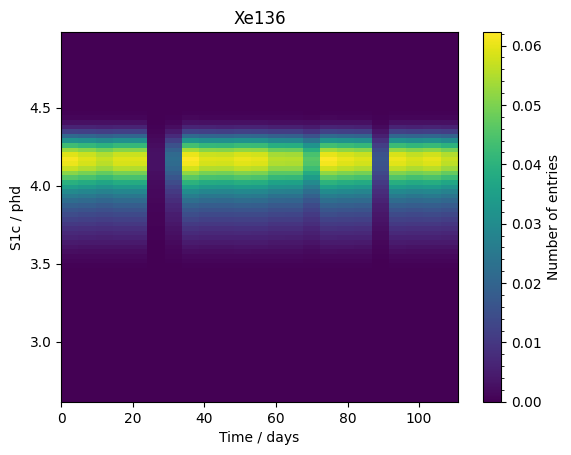

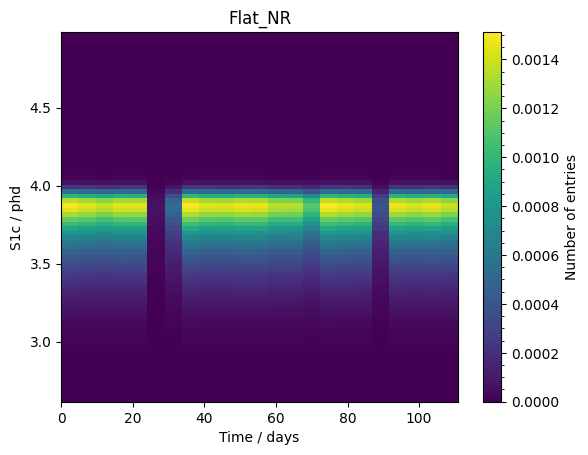

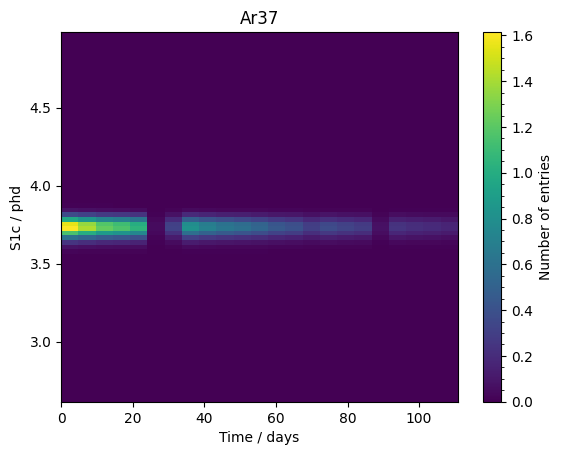

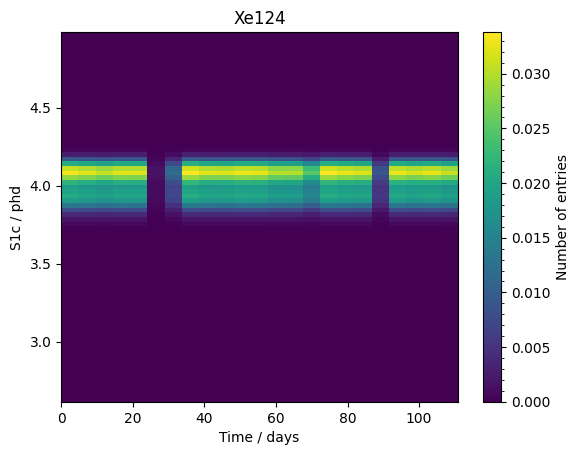

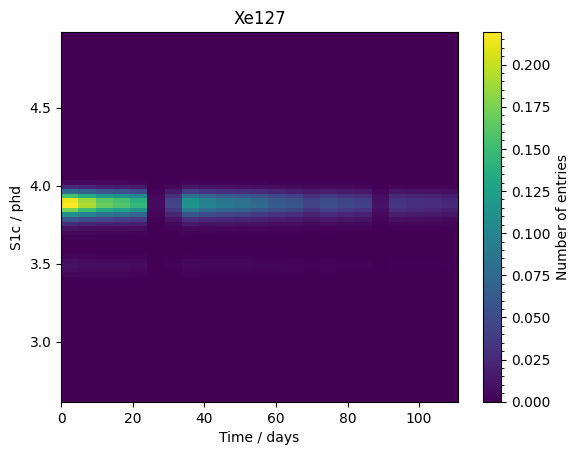

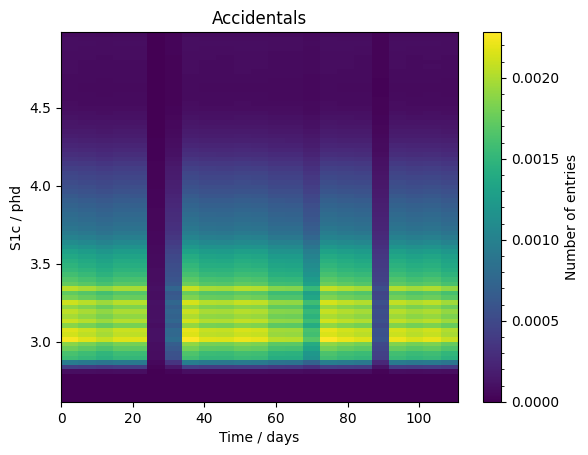

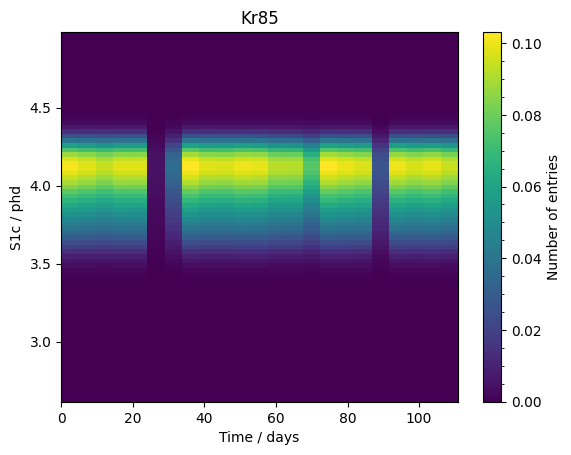

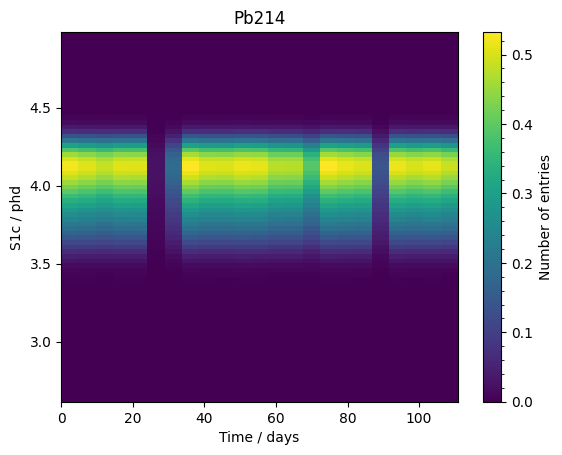

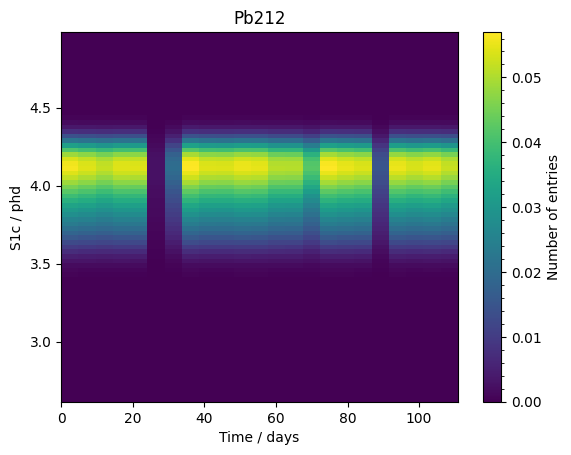

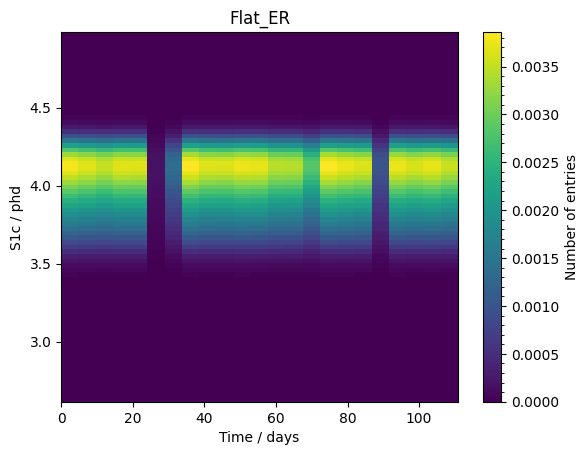

In [9]:
for background in backgrounds:
    plt.title(background)
    plt.xlabel('Time / days')
    plt.ylabel('S1c / phd')
    bkg_s2_time_dict[background].plot()
    plt.show()